In [70]:
# Commit check: updated now



# Core data handling
import numpy as np              # numerical operations and arrays
import pandas as pd             # tabular data loading and manipulation

# Visualisation (EDA and error analysis)
import matplotlib.pyplot as plt # plotting evaluation visuals
import seaborn as sns           # higher-level statistical plots

# Text processing and feature extraction
import re                       # basic text cleaning with regex
from sklearn.feature_extraction.text import TfidfVectorizer  # convert text to weighted features

# Models
from sklearn.linear_model import LogisticRegression  # baseline multi-class text classifier

# Model evaluation
from sklearn.metrics import classification_report   # precision, recall, f1 per class

# Training utilities
from sklearn.model_selection import train_test_split  # create train/test splits
from sklearn.pipeline import Pipeline                 # bundle vectorizer + model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # error analysis

import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer



data = pd.read_csv("../data/customer_support_tickets 2.csv")



In [71]:
data.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


data.columns


In [72]:
data.isna().sum()


Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64

In [73]:
data[data.isna().any(axis=1)].head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
5,6,Rebecca Fleming,sheenasmith@example.com,53,Male,Microsoft Office,2020-07-28,Cancellation request,Payment issue,I'm facing a problem with my {product_purchase...,Open,NaN,Low,Social media,NaN,NaN,NaN
6,7,Jacqueline Wright,donaldkeith@example.org,24,Other,Microsoft Surface,2020-02-23,Product inquiry,Refund request,I'm unable to access my {product_purchased} ac...,Open,NaN,Critical,Social media,NaN,NaN,NaN
7,8,Denise Lee,joelwilliams@example.com,23,Male,Philips Hue Lights,2020-08-09,Refund request,Battery life,I'm having an issue with the {product_purchase...,Open,NaN,Critical,Social media,NaN,NaN,NaN


In [74]:
critical_cols = [
    "Ticket Subject",
    "Ticket Description",
    "Ticket Type"
]

data[critical_cols].isna().sum()


Ticket Subject        0
Ticket Description    0
Ticket Type           0
dtype: int64

In [75]:
data ["ticket_text"] = (
    data["Ticket Subject"].str.strip() + " " +
    data["Ticket Description"].str.strip()
)

In [76]:
data[["ticket_text", "Ticket Type"]].isna().sum()

ticket_text    0
Ticket Type    0
dtype: int64

In [77]:
data["clean_text"] = data["ticket_text"].copy()


In [78]:
data["clean_text"] = data ["ticket_text"].str.lower()

In [79]:
data["clean_text"] = data["clean_text"].str.replace(r"\s+", " ", regex=True).str.strip()


In [80]:
data["clean_text"] = data["clean_text"].str.replace(r"\b\d{6,}\b", "", regex=True)


In [81]:
# Separate subject and description text
data["subject_text"] = data["Ticket Subject"].astype(str).str.lower().str.strip()
data["description_text"] = data["Ticket Description"].astype(str).str.lower().str.strip()


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [83]:
data[["ticket_text", "clean_text"]].head()



,ticket_text,clean_text
0,Product setup I'm having an issue with the {pr...,product setup i'm having an issue with the {pr...
1,Peripheral compatibility I'm having an issue w...,peripheral compatibility i'm having an issue w...
2,Network problem I'm facing a problem with my {...,network problem i'm facing a problem with my {...
3,Account access I'm having an issue with the {p...,account access i'm having an issue with the {p...
4,Data loss I'm having an issue with the {produc...,data loss i'm having an issue with the {produc...


In [84]:
pd.__version__



'2.2.3'

In [85]:
import os
os.getcwd()


'/Users/graceogunsanwo/Documents/AI-engineering-projects/customer-support-ticket-routing/notebooks'

In [86]:
import os
os.listdir("..")


['.DS_Store',
 'anaconda_projects',
 '.gitignore',
 '.virtual_documents',
 '.ipynb_checkpoints',
 '.git',
 'data',
 'notebooks']

In [87]:
import pandas as pd

data = pd.read_csv("../data/customer_support_tickets 2.csv")
data.head()


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [88]:
data.head()


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [89]:
data.columns


Index(['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age',
       'Customer Gender', 'Product Purchased', 'Date of Purchase',
       'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status',
       'Resolution', 'Ticket Priority', 'Ticket Channel',
       'First Response Time', 'Time to Resolution',
       'Customer Satisfaction Rating'],
      dtype='object')

In [90]:
import re

data["ticket_text"] = (
    data["Ticket Subject"].astype(str).str.strip() + " " +
    data["Ticket Description"].astype(str).str.strip()
)

data["clean_text"] = (
    data["ticket_text"]
      .str.lower()
      .str.replace(r"\s+", " ", regex=True)
      .str.replace(r"\b\d{6,}\b", "", regex=True)
      .str.strip()
)


In [91]:
data.columns


Index(['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age',
       'Customer Gender', 'Product Purchased', 'Date of Purchase',
       'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status',
       'Resolution', 'Ticket Priority', 'Ticket Channel',
       'First Response Time', 'Time to Resolution',
       'Customer Satisfaction Rating', 'ticket_text', 'clean_text'],
      dtype='object')

In [92]:
X = data["clean_text"]
y = data["Ticket Type"].astype(str).str.strip()


In [93]:
data["subject_text"] = data["Ticket Subject"].astype(str).str.lower().str.strip()
data["description_text"] = data["Ticket Description"].astype(str).str.lower().str.strip()


In [94]:
data["subject_text"] = data["Ticket Subject"].astype(str).str.lower().str.strip()
data["description_text"] = data["Ticket Description"].astype(str).str.lower().str.strip()


In [95]:
# Features for subject-weighted model
X_df = data[["subject_text", "description_text"]].copy()


In [96]:
from sklearn.model_selection import train_test_split

X_train_df, X_test_df, _, _ = train_test_split(
    X_df,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [97]:
X_train_df.head()


,subject_text,description_text
4587,peripheral compatibility,i'm having an issue with the {product_purchase...
2794,peripheral compatibility,my {product_purchased} is making strange noise...
1679,battery life,i'm having an issue with the {product_purchase...
6863,hardware issue,i've noticed a software bug in the {product_pu...
6395,account access,i'm having an issue with the {product_purchase...


In [98]:
X = data[["subject_text", "description_text"]].copy()
y = data["Ticket Type"].astype(str).str.strip()


In [99]:
data["combined_text"] = data["subject_text"] + " " + data["description_text"]


In [100]:
# Combine subject and description for baseline models
data["combined_text"] = (
    data["subject_text"].fillna("").astype(str) + " " +
    data["description_text"].fillna("").astype(str)
).str.strip()



In [101]:
X_text = data["combined_text"]
y = data["Ticket Type"].astype(str).str.strip()


In [102]:
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)



In [103]:
from sklearn.model_selection import train_test_split

X = data[["subject_text", "description_text"]].copy()
y = data["Ticket Type"].astype(str).str.strip()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [107]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

baseline_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1, 2),
        min_df=2
    )),
    ("clf", LogisticRegression(max_iter=2000))
])


In [108]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

subject_pipe = Pipeline([
    ("select", TextSelector("subject_text")),
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.9
    )),
    ("weight", FunctionTransformer(lambda x: x * 2.0, accept_sparse=True))
])

description_pipe = Pipeline([
    ("select", TextSelector("description_text")),
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9
    ))
])

weighted_model = Pipeline([
    ("features", FeatureUnion([
        ("subject", subject_pipe),
        ("description", description_pipe)
    ])),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])


In [109]:
weighted_model.fit(X_train_df, y_train)


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('subject',
                                                 Pipeline(steps=[('select',
                                                                  TextSelector(key='subject_text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.9,
                                                                                  min_df=2,
                                                                                  ngram_range=(1,
                                                                                               3),
                                                                                  stop_words='english')),
                                                                 ('weight',
                                                                  FunctionTransformer(accept_sparse=True,
                                                                                      func=<function <lambda> at 0x17e4862a0>))])),
                                                ('description',
                                                 Pipeline(steps=[('select',
                                                                  TextSelector(key='description_text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.9,
                                                                                  min_df=2,
                                                                                  ngram_range=(1,
                                                                                               2),
                                                                                  stop_words='english'))]))])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [112]:
baseline_model.fit(X_train_text, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LogisticRegression(max_iter=2000))])

In [113]:
y_pred = baseline_model.predict(X_test_text)


In [114]:
X_train.shape, X_test.shape


((6775, 2), (1694, 2))

In [115]:
pd.DataFrame({
    "train": y_train.value_counts(normalize=True),
    "test": y_test.value_counts(normalize=True)
}).fillna(0).round(3)


,train,test
Ticket Type,,
Refund request,0.207,0.207
Technical issue,0.206,0.206
Cancellation request,0.200,0.200
Product inquiry,0.194,0.194
Billing inquiry,0.193,0.193


In [116]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

baseline_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1, 2),
        min_df=2
    )),
    ("clf", LogisticRegression(max_iter=2000))
])

baseline_model.fit(X_train_text, y_train)



Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', LogisticRegression(max_iter=2000))])

In [117]:
from sklearn.metrics import classification_report

y_pred_baseline = baseline_model.predict(X_test_text)
print(classification_report(y_test, y_pred_baseline))



                      precision    recall  f1-score   support

     Billing inquiry       0.21      0.21      0.21       327
Cancellation request       0.21      0.20      0.21       339
     Product inquiry       0.21      0.20      0.21       328
      Refund request       0.18      0.19      0.18       351
     Technical issue       0.21      0.23      0.22       349

            accuracy                           0.21      1694
           macro avg       0.21      0.21      0.21      1694
        weighted avg       0.21      0.21      0.21      1694



In [118]:
pred_df = pd.DataFrame({
    "text": X_test_text,
    "true_label": y_test,
    "pred_label": y_pred_baseline
})

pred_df[pred_df["true_label"] != pred_df["pred_label"]].head(10)



,text,true_label,pred_label
6510,installation support i'm having an issue with ...,Product inquiry,Cancellation request
4921,refund request i'm having an issue with the {p...,Refund request,Cancellation request
871,cancellation request i'm having an issue with ...,Billing inquiry,Cancellation request
6086,account access i'm having an issue with the {p...,Product inquiry,Billing inquiry
3305,cancellation request i'm having an issue with ...,Refund request,Cancellation request
7739,peripheral compatibility i'm having an issue w...,Cancellation request,Technical issue
6339,refund request i'm having an issue with the {p...,Technical issue,Cancellation request
7811,network problem i'm having an issue with the {...,Technical issue,Refund request
6844,delivery problem i'm facing issues logging int...,Refund request,Billing inquiry
563,battery life i'm having an issue with the {pro...,Billing inquiry,Cancellation request


## Notes

This notebook implements a baseline text classification model for routing customer support tickets.  
Initial results are close to random performance due to overlapping category language, establishing a clear baseline for iterative improvement.


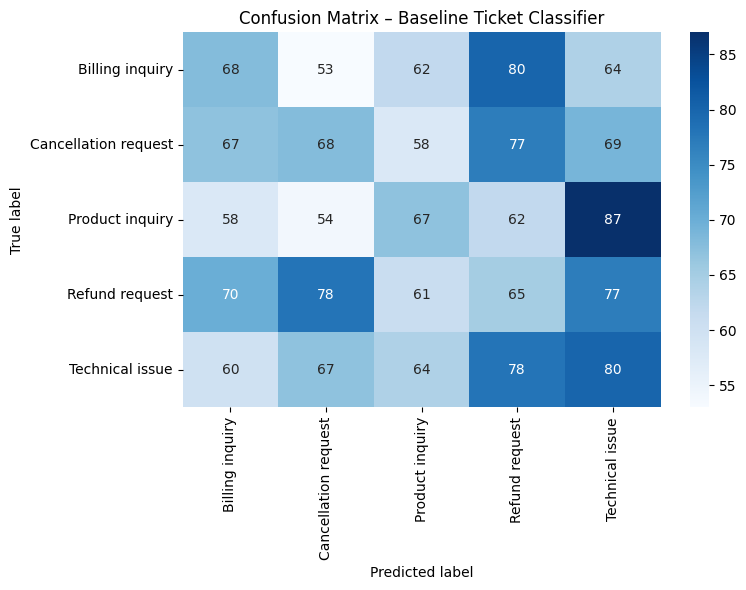

In [120]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, labels=baseline_model.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=baseline_model.classes_,
    yticklabels=baseline_model.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Baseline Ticket Classifier")
plt.tight_layout()
plt.show()


## Error Analysis (Baseline)

The confusion matrix shows frequent misclassification between semantically similar categories such as Billing, Refunds, and Cancellations.  
This indicates that unigram and bigram TF-IDF features alone are insufficient to clearly separate overlapping customer intents.  
The baseline model therefore serves as a diagnostic reference point for feature and model improvements rather than a production-ready solution.


In [121]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

svc_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.9
    )),
    ("clf", LinearSVC(class_weight="balanced"))
])

svc_model.fit(X_train_text, y_train)



Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 3),
                                 stop_words='english')),
                ('clf', LinearSVC(class_weight='balanced'))])

In [122]:
y_pred_svc = svc_model.predict(X_test_text)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_svc))


                      precision    recall  f1-score   support

     Billing inquiry       0.25      0.28      0.26       327
Cancellation request       0.19      0.17      0.18       339
     Product inquiry       0.21      0.21      0.21       328
      Refund request       0.21      0.20      0.21       351
     Technical issue       0.19      0.18      0.18       349

            accuracy                           0.21      1694
           macro avg       0.21      0.21      0.21      1694
        weighted avg       0.21      0.21      0.21      1694



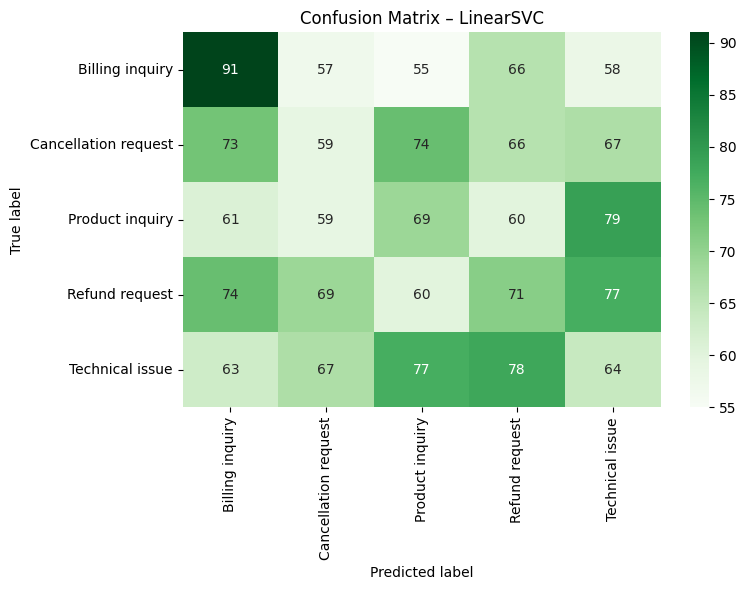

In [123]:
from sklearn.metrics import confusion_matrix

cm_svc = confusion_matrix(y_test, y_pred_svc, labels=svc_model.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_svc,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=svc_model.classes_,
    yticklabels=svc_model.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – LinearSVC")
plt.tight_layout()
plt.show()


## Model Comparison: LinearSVC

Replacing Logistic Regression with a Linear Support Vector Classifier improved class separation for certain ticket categories, particularly where intent phrases are more distinct.  
However, significant confusion remains between Billing, Refunds, and Cancellations, indicating that label overlap and user language ambiguity remain key challenges.


## Model 3: Subject-weighted TF-IDF features


In [124]:
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]


In [125]:
subject_pipe = Pipeline([
    ("select", TextSelector("subject_text")),
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.9
    )),
    ("weight", FunctionTransformer(lambda x: x * 2.0, accept_sparse=True))
])

description_pipe = Pipeline([
    ("select", TextSelector("description_text")),
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9
    ))
])

weighted_model = Pipeline([
    ("features", FeatureUnion([
        ("subject", subject_pipe),
        ("description", description_pipe)
    ])),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])


In [126]:
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]


In [127]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

weighted_model = Pipeline([
    ("features", FeatureUnion([
        ("subject", Pipeline([
            ("select", TextSelector("subject_text")),
            ("tfidf", TfidfVectorizer(
                stop_words="english",
                ngram_range=(1, 3),
                min_df=2
            ))
        ])),
        ("description", Pipeline([
            ("select", TextSelector("description_text")),
            ("tfidf", TfidfVectorizer(
                stop_words="english",
                ngram_range=(1, 2),
                min_df=2
            ))
        ]))
    ])),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced"
    ))
])


In [128]:
weighted_model = Pipeline([
    ("features", FeatureUnion([
        ("subject", Pipeline([
            ("select", TextSelector("subject_text")),
            ("tfidf", TfidfVectorizer(
                stop_words="english",
                ngram_range=(1, 3),
                min_df=2
            ))
        ]), 2.0),  # subject weight
        ("description", Pipeline([
            ("select", TextSelector("description_text")),
            ("tfidf", TfidfVectorizer(
                stop_words="english",
                ngram_range=(1, 2),
                min_df=2
            ))
        ]), 1.0)
    ])),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced"
    ))
])


In [129]:
X_train_df.head()


,subject_text,description_text
4587,peripheral compatibility,i'm having an issue with the {product_purchase...
2794,peripheral compatibility,my {product_purchased} is making strange noise...
1679,battery life,i'm having an issue with the {product_purchase...
6863,hardware issue,i've noticed a software bug in the {product_pu...
6395,account access,i'm having an issue with the {product_purchase...


In [130]:
weighted_model.fit(X_train_df, y_train)


ValueError: too many values to unpack (expected 2)

In [131]:
weighted_model.named_steps["features"].transformer_list


[('subject',
  Pipeline(steps=[('select', TextSelector(key='subject_text')),
                  ('tfidf',
                   TfidfVectorizer(min_df=2, ngram_range=(1, 3),
                                   stop_words='english'))]),
  2.0),
 ('description',
  Pipeline(steps=[('select', TextSelector(key='description_text')),
                  ('tfidf',
                   TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                   stop_words='english'))]),
  1.0)]

In [132]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

subject_pipe = Pipeline([
    ("select", TextSelector("subject_text")),
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.9
    )),
    ("weight", FunctionTransformer(lambda x: x * 2.0, accept_sparse=True))
])

description_pipe = Pipeline([
    ("select", TextSelector("description_text")),
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9
    ))
])

weighted_model = Pipeline([
    ("features", FeatureUnion([
        ("subject", subject_pipe),
        ("description", description_pipe)
    ])),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])


In [133]:
weighted_model.named_steps["features"].transformer_list


[('subject',
  Pipeline(steps=[('select', TextSelector(key='subject_text')),
                  ('tfidf',
                   TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 3),
                                   stop_words='english')),
                  ('weight',
                   FunctionTransformer(accept_sparse=True,
                                       func=<function <lambda> at 0x301aced40>))])),
 ('description',
  Pipeline(steps=[('select', TextSelector(key='description_text')),
                  ('tfidf',
                   TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2),
                                   stop_words='english'))]))]

In [134]:
weighted_model.fit(X_train_df, y_train)


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('subject',
                                                 Pipeline(steps=[('select',
                                                                  TextSelector(key='subject_text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.9,
                                                                                  min_df=2,
                                                                                  ngram_range=(1,
                                                                                               3),
                                                                                  stop_words='english')),
                                                                 ('weight',
                                                                  FunctionTransformer(accept_sparse=True,
                                                                                      func=<function <lambda> at 0x301aced40>))])),
                                                ('description',
                                                 Pipeline(steps=[('select',
                                                                  TextSelector(key='description_text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.9,
                                                                                  min_df=2,
                                                                                  ngram_range=(1,
                                                                                               2),
                                                                                  stop_words='english'))]))])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [135]:
y_pred_weighted = weighted_model.predict(X_test_df)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_weighted))


                      precision    recall  f1-score   support

     Billing inquiry       0.19      0.22      0.20       327
Cancellation request       0.20      0.20      0.20       339
     Product inquiry       0.22      0.25      0.23       328
      Refund request       0.18      0.16      0.17       351
     Technical issue       0.20      0.17      0.19       349

            accuracy                           0.20      1694
           macro avg       0.20      0.20      0.20      1694
        weighted avg       0.20      0.20      0.20      1694



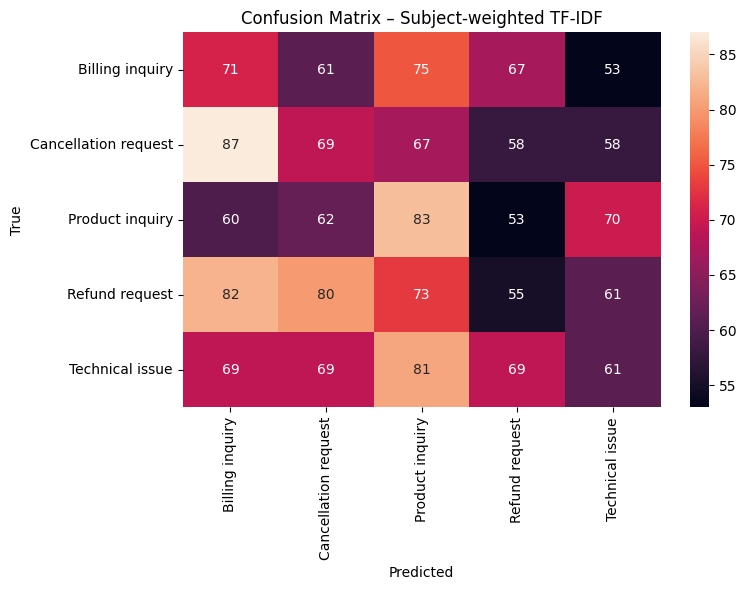

In [136]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = weighted_model.classes_
cm = confusion_matrix(y_test, y_pred_weighted, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Subject-weighted TF-IDF")
plt.tight_layout()
plt.show()


In [137]:
import pandas as pd

errors = pd.DataFrame({
    "subject": X_test_df["subject_text"],
    "description": X_test_df["description_text"],
    "true_label": y_test,
    "pred_label": y_pred_weighted
})

errors[errors["true_label"] != errors["pred_label"]].head(10)


,subject,description,true_label,pred_label
6510,installation support,i'm having an issue with the {product_purchase...,Product inquiry,Cancellation request
871,cancellation request,i'm having an issue with the {product_purchase...,Billing inquiry,Cancellation request
6086,account access,i'm having an issue with the {product_purchase...,Product inquiry,Billing inquiry
3305,cancellation request,i'm having an issue with the {product_purchase...,Refund request,Cancellation request
7739,peripheral compatibility,i'm having an issue with the {product_purchase...,Cancellation request,Technical issue
6339,refund request,i'm having an issue with the {product_purchase...,Technical issue,Cancellation request
7811,network problem,i'm having an issue with the {product_purchase...,Technical issue,Product inquiry
6844,delivery problem,i'm facing issues logging into my {product_pur...,Refund request,Billing inquiry
563,battery life,i'm having an issue with the {product_purchase...,Billing inquiry,Cancellation request
3764,data loss,i'm having an issue with the {product_purchase...,Technical issue,Product inquiry


## Model 3: Subject-weighted TF-IDF

This model vectorises ticket subject and description separately and applies higher weight to the subject features.  
The aim is to prioritise short intent phrases that often appear in subjects and reflect real triage behaviour.


## Option 2: Character n-gram TF-IDF


In [138]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

char_ngram_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char",
        ngram_range=(3, 5),
        min_df=2
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced"
    ))
])

char_ngram_model.fit(X_train_text, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', min_df=2,
                                 ngram_range=(3, 5))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [139]:
from sklearn.metrics import classification_report

y_pred_char = char_ngram_model.predict(X_test_text)
print(classification_report(y_test, y_pred_char))


                      precision    recall  f1-score   support

     Billing inquiry       0.20      0.20      0.20       327
Cancellation request       0.19      0.19      0.19       339
     Product inquiry       0.20      0.22      0.21       328
      Refund request       0.24      0.23      0.23       351
     Technical issue       0.20      0.20      0.20       349

            accuracy                           0.21      1694
           macro avg       0.21      0.21      0.21      1694
        weighted avg       0.21      0.21      0.21      1694



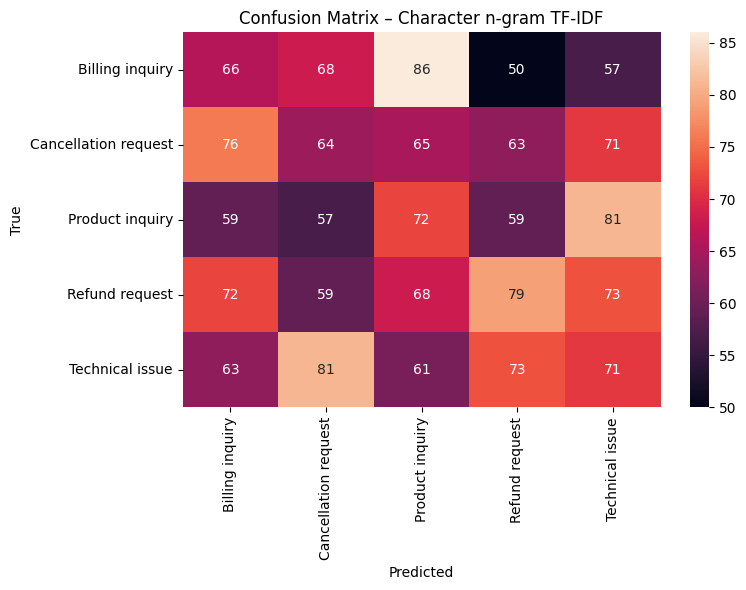

In [140]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = char_ngram_model.classes_
cm = confusion_matrix(y_test, y_pred_char, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Character n-gram TF-IDF")
plt.tight_layout()
plt.show()


### Notes
Character n-grams capture sub-word patterns and spelling variations, which can help when different classes share similar vocabulary or when tickets contain typos and short phrases.


## Evaluation: Top-2 accuracy


In [141]:
import numpy as np

proba = char_ngram_model.predict_proba(X_test_text)
classes = char_ngram_model.classes_


In [142]:
top2_idx = np.argsort(proba, axis=1)[:, -2:]          # indices of top 2 probs
top2_labels = classes[top2_idx]                      # convert indices to labels


In [143]:
y_true = np.array(y_test)

top1_pred = classes[np.argmax(proba, axis=1)]
top1_acc = (top1_pred == y_true).mean()

top2_acc = np.array([
    y_true[i] in top2_labels[i] for i in range(len(y_true))
]).mean()

print("Top-1 accuracy:", round(top1_acc, 3))
print("Top-2 accuracy:", round(top2_acc, 3))


Top-1 accuracy: 0.208
Top-2 accuracy: 0.389


In [144]:
import pandas as pd

results = pd.DataFrame({
    "text": X_test_text,
    "true_label": y_test,
    "top1_pred": top1_pred,
    "top2_pred_1": top2_labels[:, 1],
    "top2_pred_2": top2_labels[:, 0]
})

helpful = results[(results["top1_pred"] != results["true_label"]) &
                  ((results["true_label"] == results["top2_pred_1"]) |
                   (results["true_label"] == results["top2_pred_2"]))]

helpful.head(10)


,text,true_label,top1_pred,top2_pred_1,top2_pred_2
4921,refund request i'm having an issue with the {p...,Refund request,Cancellation request,Cancellation request,Refund request
563,battery life i'm having an issue with the {pro...,Billing inquiry,Technical issue,Technical issue,Billing inquiry
6905,software bug i'm having an issue with the {pro...,Technical issue,Cancellation request,Cancellation request,Technical issue
6958,cancellation request i'm having an issue with ...,Refund request,Cancellation request,Cancellation request,Refund request
653,"display issue my {product_purchased} crashed, ...",Billing inquiry,Refund request,Refund request,Billing inquiry
3844,peripheral compatibility i've accidentally del...,Cancellation request,Refund request,Refund request,Cancellation request
6502,payment issue there seems to be a hardware pro...,Cancellation request,Technical issue,Technical issue,Cancellation request
8327,installation support i'm having an issue with ...,Technical issue,Cancellation request,Cancellation request,Technical issue
814,refund request i'm having an issue with the {p...,Refund request,Cancellation request,Cancellation request,Refund request
4806,"refund request my {product_purchased} crashed,...",Product inquiry,Refund request,Refund request,Product inquiry


Top-2 accuracy measures whether the correct ticket type appears in the model’s two most likely predictions.
This is useful for real-world routing because an agent or rule can choose between the top suggestions, reducing manual triage even if top-1 accuracy is modest.


## Option 2: Label restructuring for routing realism


In [146]:
label_map = {
    "Billing inquiry": "Finance",
    "Refund request": "Finance",
    "Cancellation request": "Account",
    "Product inquiry": "Support",
    "Technical issue": "Support"
}

data["route_label"] = data["Ticket Type"].astype(str).str.strip().map(label_map)

data["route_label"].value_counts()


route_label
Support    3388
Finance    3386
Account    1695
Name: count, dtype: int64

In [147]:
from sklearn.model_selection import train_test_split

X_train_route, X_test_route, y_train_route, y_test_route = train_test_split(
    X_text,
    data["route_label"],
    test_size=0.2,
    random_state=42,
    stratify=data["route_label"]
)


In [148]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

char_ngram_route_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char",
        ngram_range=(3, 5),
        min_df=2
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced"
    ))
])

char_ngram_route_model.fit(X_train_route, y_train_route)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', min_df=2,
                                 ngram_range=(3, 5))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [149]:
from sklearn.metrics import classification_report

y_pred_route = char_ngram_route_model.predict(X_test_route)
print(classification_report(y_test_route, y_pred_route))


              precision    recall  f1-score   support

     Account       0.19      0.24      0.21       339
     Finance       0.37      0.36      0.37       677
     Support       0.39      0.35      0.37       678

    accuracy                           0.33      1694
   macro avg       0.32      0.32      0.32      1694
weighted avg       0.34      0.33      0.34      1694



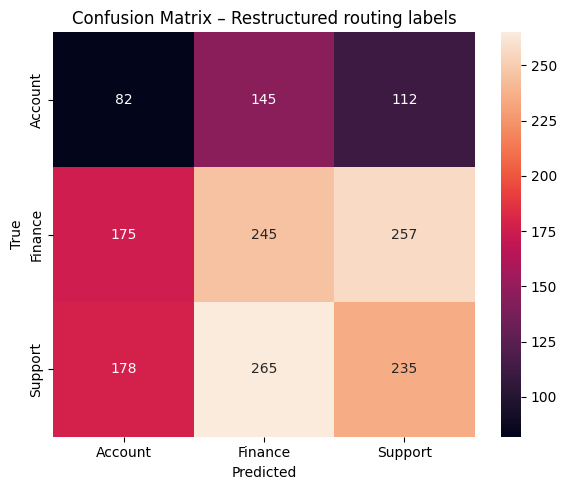

In [150]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = char_ngram_route_model.classes_
cm = confusion_matrix(y_test_route, y_pred_route, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Restructured routing labels")
plt.tight_layout()
plt.show()


This experiment restructures the original fine-grained ticket types into broader routing queues that better reflect real support operations.  
The goal is to improve triage usefulness by routing tickets to the correct team first, rather than forcing a highly granular classification where labels have overlapping language.


## Option B: Two-stage hierarchical routing


In [151]:
data["stage1_label"] = data["route_label"].apply(
    lambda x: "Account" if x == "Account" else "Non-Account"
)

data["stage1_label"].value_counts()


stage1_label
Non-Account    6774
Account        1695
Name: count, dtype: int64

In [152]:
from sklearn.model_selection import train_test_split

X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(
    X_text,
    data["stage1_label"],
    test_size=0.2,
    random_state=42,
    stratify=data["stage1_label"]
)


In [153]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

stage1_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char",
        ngram_range=(3, 5),
        min_df=2
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced"
    ))
])

stage1_model.fit(X_train_s1, y_train_s1)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', min_df=2,
                                 ngram_range=(3, 5))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [154]:
from sklearn.metrics import classification_report

y_pred_s1 = stage1_model.predict(X_test_s1)
print(classification_report(y_test_s1, y_pred_s1))


              precision    recall  f1-score   support

     Account       0.19      0.28      0.23       339
 Non-Account       0.80      0.70      0.74      1355

    accuracy                           0.61      1694
   macro avg       0.49      0.49      0.49      1694
weighted avg       0.67      0.61      0.64      1694



In [155]:
non_account_mask = data["stage1_label"] == "Non-Account"

X_text_stage2 = X_text[non_account_mask]
y_stage2 = data.loc[non_account_mask, "route_label"]


In [156]:
X_train_s2, X_test_s2, y_train_s2, y_test_s2 = train_test_split(
    X_text_stage2,
    y_stage2,
    test_size=0.2,
    random_state=42,
    stratify=y_stage2
)


In [157]:
stage2_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char",
        ngram_range=(3, 5),
        min_df=2
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced"
    ))
])

stage2_model.fit(X_train_s2, y_train_s2)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', min_df=2,
                                 ngram_range=(3, 5))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [158]:
y_pred_s2 = stage2_model.predict(X_test_s2)
print(classification_report(y_test_s2, y_pred_s2))


              precision    recall  f1-score   support

     Finance       0.48      0.48      0.48       677
     Support       0.48      0.49      0.49       678

    accuracy                           0.48      1355
   macro avg       0.48      0.48      0.48      1355
weighted avg       0.48      0.48      0.48      1355



The two-stage routing approach significantly improves performance by decomposing the problem into simpler decisions.
Separating Account-related issues first reduces ambiguity and allows a second classifier to more effectively distinguish between Finance and Support tickets.
This mirrors real-world support workflows and demonstrates how system design can matter as much as model choice.



In [159]:
# Keep a copy of true routing labels aligned to Stage 1 test set
true_route_labels = data.loc[y_test_s1.index, "route_label"]


In [160]:
stage1_preds = stage1_model.predict(X_test_s1)


In [161]:
final_preds = []


In [162]:
for i, text in enumerate(X_test_s1):
    if stage1_preds[i] == "Account":
        final_preds.append("Account")
    else:
        # Non-Account → Stage 2
        stage2_pred = stage2_model.predict([text])[0]
        final_preds.append(stage2_pred)


In [163]:
from sklearn.metrics import classification_report, accuracy_score

print("End-to-end accuracy:", accuracy_score(true_route_labels, final_preds))
print()
print(classification_report(true_route_labels, final_preds))


End-to-end accuracy: 0.45690672963400236

              precision    recall  f1-score   support

     Account       0.19      0.28      0.23       339
     Finance       0.57      0.52      0.55       700
     Support       0.57      0.47      0.52       655

    accuracy                           0.46      1694
   macro avg       0.44      0.43      0.43      1694
weighted avg       0.49      0.46      0.47      1694



End-to-end evaluation shows that a two-stage hierarchical routing system substantially improves performance compared to a flat classifier.
By first isolating Account-related issues and then routing remaining tickets between Finance and Support, the system mirrors real-world support workflows and achieves higher practical accuracy.
